# Задание
Чем активнее наши пользователи – тем выше нагрузка на сервера. И в последнее время нам всё чаще приходят жалобы, что приложение подвисает. Звучит как задача для девопсов и инженеров!

От вас тоже попросили внести свой вклад в задачу – спрогнозировать, как изменится активность пользователей в течение ближайшего месяца. Давайте попробуем это сделать!

1. Выберите основную метрику, которую вы планируете прогнозировать. Обоснуйте, почему именно она. Какое временное разрешение вы возьмёте? Будут ли какие-то дополнительные регрессоры, которые вы включите в модель?

2. Постройте модель и провалидируйте её. Хватает ли у нас данных для бэктестинга с текущей задачей? Если нет, то определите, для какого горизонта прогнозирования у нас хватает данных.

3. Выберите ту модель, которая кажется вам наиболее удачной (обоснуйте выбор). Проинтерпретируйте её результаты. Если есть какие-то важные ограничения по выводу – не забудьте их тоже указать.

# Выбор метрики
Так как нам известно, что чем активнее наши пользователи тем сильнее нагрузка на сервера, то в качестве основной метрики которую будем предсказывать выберем общее количество действий (просмотры + лайки + сообщения) в день. В качестве ковариата добавим DAU, так же учтем аномальную активность во время проведенного флэшмоба.

In [1]:
# импортируем необходимые библиотеки
import orbit
from orbit.models import DLT
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.diagnostics.backtest import BackTester
from orbit.diagnostics.metrics import mae, mse, smape, wmape

import pandas as pd
import pandahouse as ph
import numpy as np
import os

import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

sns.set(rc={'figure.figsize':(16,6)}, style="whitegrid")

# Готовим данные

Для построения модели возьмем данные за 10 недель с момента запуска приложения

In [2]:
# подключаемся к ClickHouse и считываем необходимые данные
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20230820',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

q = '''
SELECT
    toStartOfDay(time) day_time,
    uniqExact(user_id) DAU,
    count(action) activity
FROM 
    {db}.feed_actions 
WHERE
    toStartOfDay(time) <= '2023-09-10' 
GROUP BY
    day_time
ORDER BY
    day_time
'''

q_mes = '''
SELECT
    toStartOfDay(time) day_time,
    count(reciever_id) mes_activity
FROM 
    {db}.message_actions 
WHERE
    toStartOfDay(time) <= '2023-09-10' 
GROUP BY
    day_time
ORDER BY
    day_time
'''


df = ph.read_clickhouse(q, connection=connection)
df_mes = ph.read_clickhouse(q_mes, connection=connection)
act_df = df.merge(df_mes)

In [3]:
act_df.head()

,day_time,DAU,activity,mes_activity
0,2023-07-03,878,9163,3226
1,2023-07-04,2238,75586,12895
2,2023-07-05,3105,126484,12897
3,2023-07-06,3721,142796,12897
4,2023-07-07,4617,208958,12898


In [4]:
del df_mes

In [5]:
act_df["total_activity"] = act_df["activity"] + act_df["mes_activity"]
act_df.head()

,day_time,DAU,activity,mes_activity,total_activity
0,2023-07-03,878,9163,3226,12389
1,2023-07-04,2238,75586,12895,88481
2,2023-07-05,3105,126484,12897,139381
3,2023-07-06,3721,142796,12897,155693
4,2023-07-07,4617,208958,12898,221856


Порисуем это всё для общей оценки:

<Axes: xlabel='day_time', ylabel='DAU'>

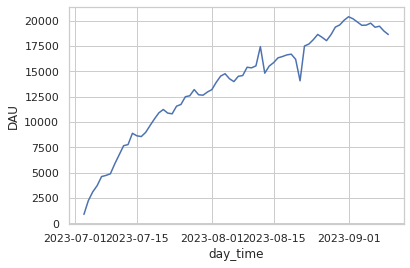

In [6]:
sns.lineplot(data=act_df, x="day_time", y="DAU")

<Axes: xlabel='day_time', ylabel='activity'>

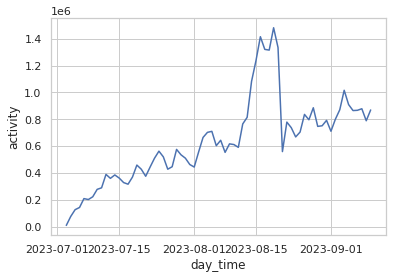

In [7]:
sns.lineplot(data=act_df, x="day_time", y="activity")

<Axes: xlabel='day_time', ylabel='mes_activity'>

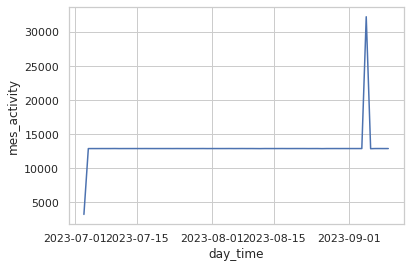

In [8]:
sns.lineplot(data=act_df, x="day_time", y="mes_activity")

<Axes: xlabel='day_time', ylabel='total_activity'>

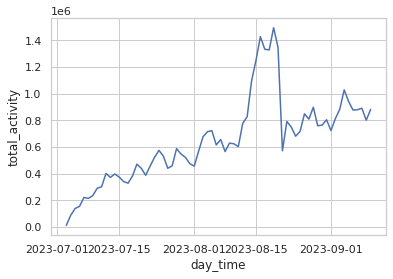

In [9]:
sns.lineplot(data=act_df, x="day_time", y="total_activity")

Отметим ещё бинарным образом промежуток от 2023-08-12 по 2023-08-20, чтоб учесть в прогнозе аномально высокую активность во время проведения флэшмоба:

In [10]:
act_df["anomaly"] = np.where((act_df.day_time >= "2023-08-12") & (act_df.day_time <= "2023-08-20"), 1, 0)
act_df.head()

,day_time,DAU,activity,mes_activity,total_activity,anomaly
0,2023-07-03,878,9163,3226,12389,0
1,2023-07-04,2238,75586,12895,88481,0
2,2023-07-05,3105,126484,12897,139381,0
3,2023-07-06,3721,142796,12897,155693,0
4,2023-07-07,4617,208958,12898,221856,0


Для первичной работы лучше стандартизовать наши модели:

In [11]:
act_mean = act_df.total_activity.mean()
act_sd = act_df.total_activity.std()

dau_mean = act_df.DAU.mean()
dau_sd = act_df.DAU.std()

act_df["DAU_stand"] = (act_df.DAU - dau_mean) / dau_sd
act_df["act_stand"] = (act_df.total_activity - act_mean) / act_sd

In [12]:
act_df.head()

,day_time,DAU,activity,mes_activity,total_activity,anomaly,DAU_stand,act_stand
0,2023-07-03,878,9163,3226,12389,0,-2.516425,-1.988550
1,2023-07-04,2238,75586,12895,88481,0,-2.247783,-1.751385
2,2023-07-05,3105,126484,12897,139381,0,-2.076523,-1.592739
3,2023-07-06,3721,142796,12897,155693,0,-1.954844,-1.541897
4,2023-07-07,4617,208958,12898,221856,0,-1.777857,-1.335679


# Строим модели

Какие модели у нас будут:

1. Обычная модель с линейным трендом
2. Обычная модель с логлинейным трендом
3. Линейный тренд + DAU как регрессор
4. Логлинейный тренд + DAU как регрессор
5. Линейный тренд + DAU + аномалия
6. Логлинейный тренд + DAU + аномалия

In [13]:
simple_lin = DLT(response_col="act_stand", 
                 date_col="day_time", 
                 estimator="stan-mcmc", 
                 global_trend_option="linear",
                 num_warmup=10000,
                 num_sample=10000)

simple_loglin = DLT(response_col="act_stand", 
                 date_col="day_time", 
                 estimator="stan-mcmc", 
                 global_trend_option="loglinear",
                 num_warmup=10000,
                 num_sample=10000)

dau_lin = DLT(response_col="act_stand", 
            date_col="day_time", 
            estimator="stan-mcmc", 
            global_trend_option="linear", 
            regressor_col=["DAU_stand"], regressor_sign=["+"], 
            num_warmup=10000,
            num_sample=10000)

dau_loglin = DLT(response_col="act_stand", 
               date_col="day_time", 
               estimator="stan-mcmc", 
               global_trend_option="loglinear",
               regressor_col=["DAU_stand"], regressor_sign=["+"], 
               num_warmup=10000,
               num_sample=10000)

anom_lin = DLT(response_col="act_stand", 
            date_col="day_time", 
            estimator="stan-mcmc", 
            global_trend_option="linear", 
            regressor_col=["DAU_stand", "anomaly"], regressor_sign=["+", "+"], 
            num_warmup=10000,
            num_sample=10000)

anom_loglin = DLT(response_col="act_stand", 
               date_col="day_time", 
               estimator="stan-mcmc", 
               global_trend_option="loglinear",
               regressor_col=["DAU_stand", "anomaly"], regressor_sign=["+", "+"], 
               num_warmup=10000,
               num_sample=10000)

In [14]:
#положим в список

model_list = [simple_lin, simple_loglin, dau_lin, dau_loglin, anom_lin, anom_loglin]

In [15]:
#обучаем

for model in model_list:
    
    model.fit(act_df)

2023-09-14 10:14:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:15:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:15:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:15:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:16:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:16:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Чтобы оценить предсказания, нам надо сотворить future df для наших моделек. Начнём с первых двух:

In [16]:
futur = model_list[0].make_future_df(periods=30)

In [17]:
pred_1 = model_list[0].predict(futur)
pred_2 = model_list[1].predict(futur)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

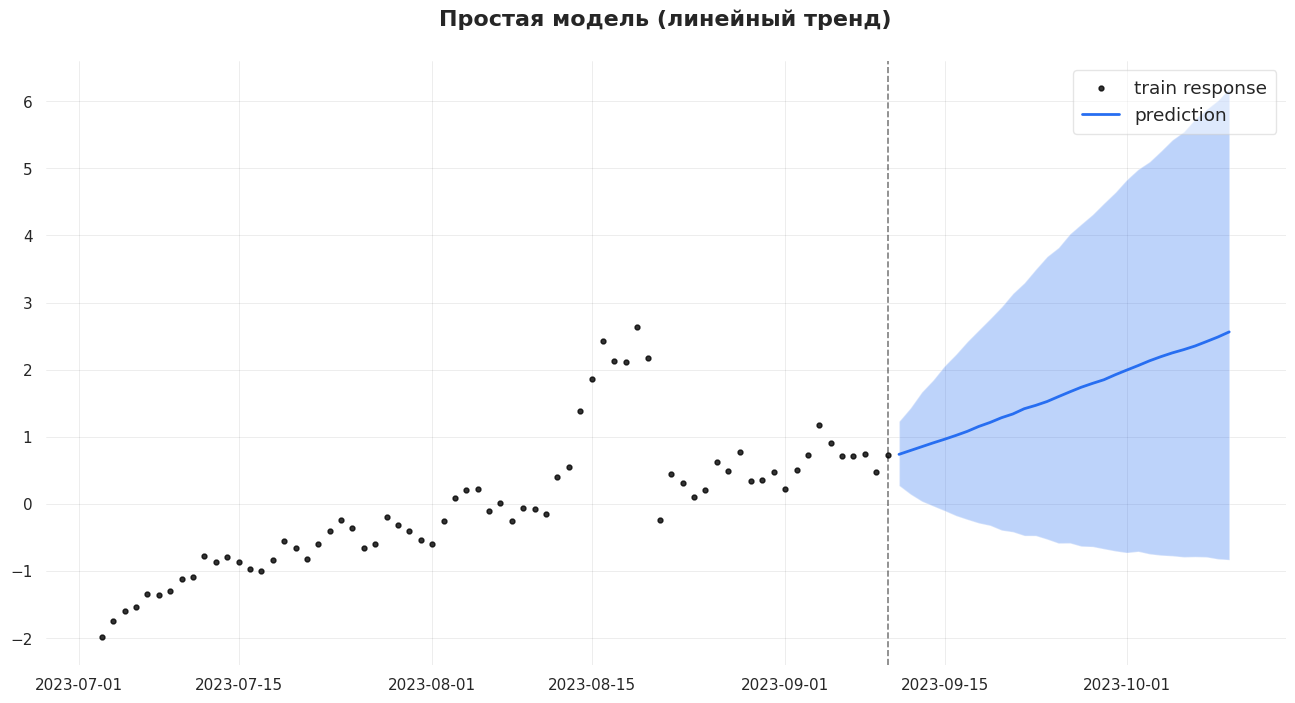

In [18]:
_ = plot_predicted_data(act_df, pred_1, "day_time", 'act_stand', title='Простая модель (линейный тренд)')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

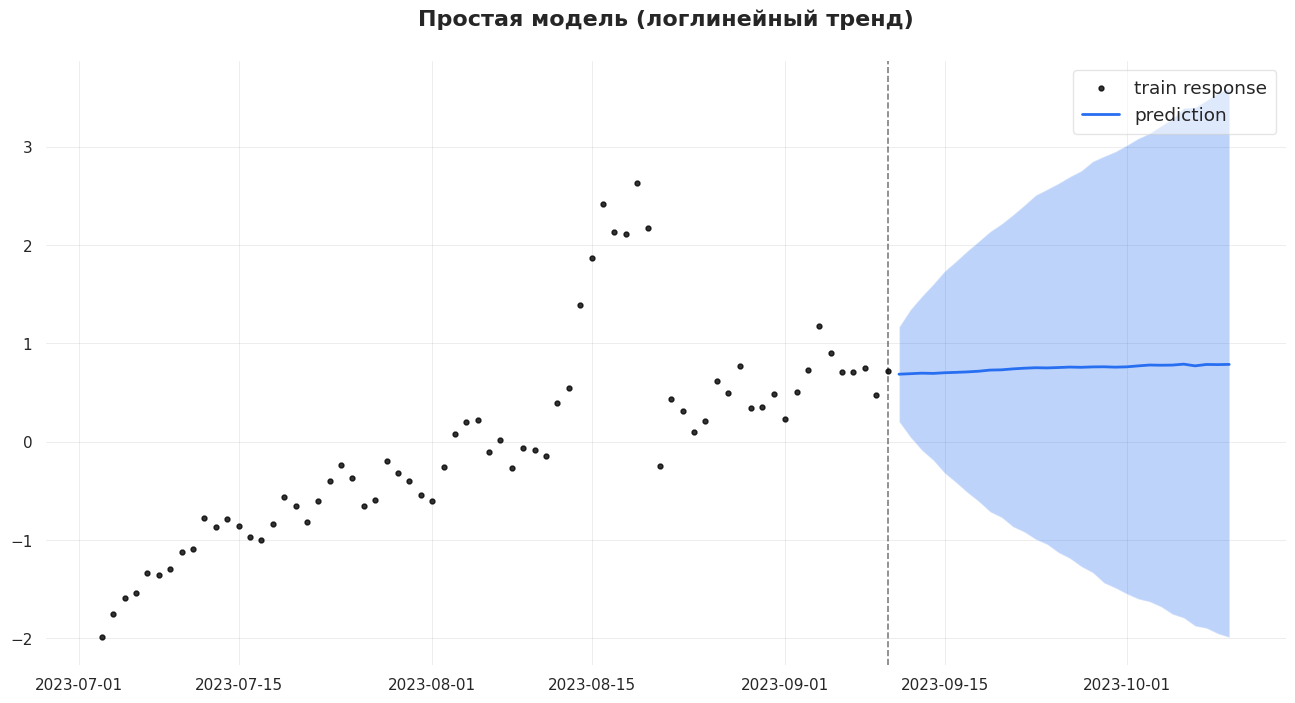

In [19]:
_ = plot_predicted_data(act_df, pred_2, "day_time", 'act_stand', title='Простая модель (логлинейный тренд)')

Для полагающихся на DAU моделей нам нужно дополнить наш df предсказаниями будущего DAU:

In [20]:
dau_model = DLT(response_col="DAU_stand", 
                 date_col="day_time", 
                 estimator="stan-mcmc", 
                 global_trend_option="linear",
                 num_warmup=10000,
                 num_sample=10000)

dau_model.fit(act_df)
dau_pred = dau_model.predict(futur)

2023-09-14 10:16:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

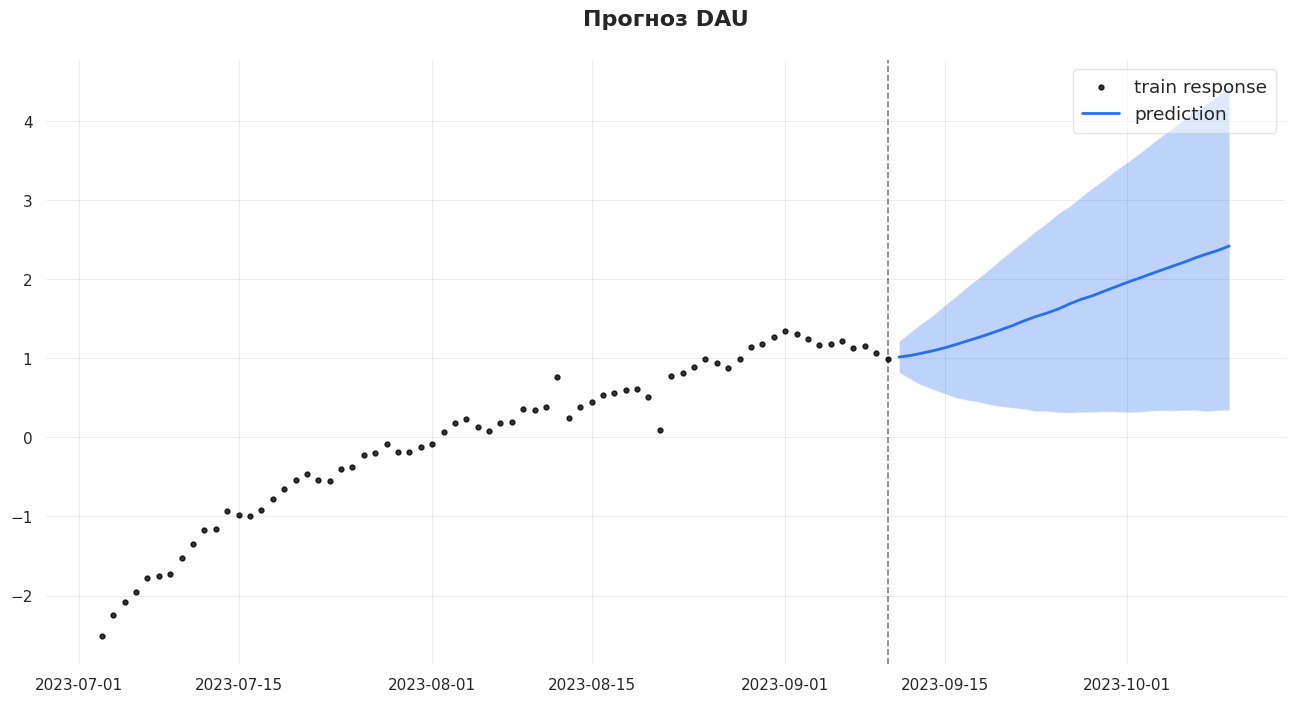

In [21]:
_ = plot_predicted_data(act_df, dau_pred, "day_time", 'DAU_stand', title='Прогноз DAU')

Добавим линейный прогноз в наш будущий df:

In [22]:
futur["DAU_stand"] = dau_pred.prediction
futur.head()

,day_time,DAU_stand
0,2023-09-11,1.014788
1,2023-09-12,1.034454
2,2023-09-13,1.063135
3,2023-09-14,1.095227
4,2023-09-15,1.130807


In [23]:
model_list[2].get_regression_coefs()

,regressor,regressor_sign,coefficient,coefficient_lower,coefficient_upper,Pr(coef >= 0),Pr(coef < 0)
0,DAU_stand,Positive,0.75267,0.289069,1.228863,1.0,0.0


In [24]:
pred_3 = model_list[2].predict(futur)
pred_4 = model_list[3].predict(futur)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

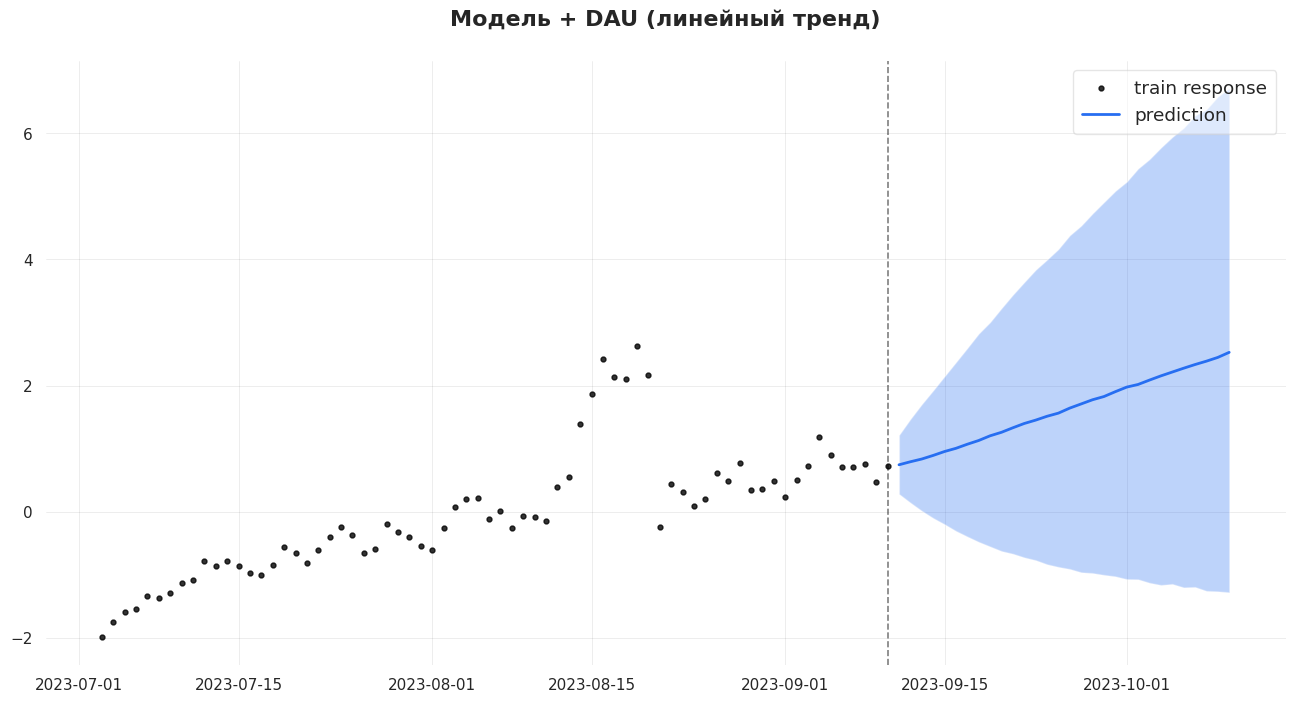

In [25]:
_ = plot_predicted_data(act_df, pred_3, "day_time", 'act_stand', title='Модель + DAU (линейный тренд)')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

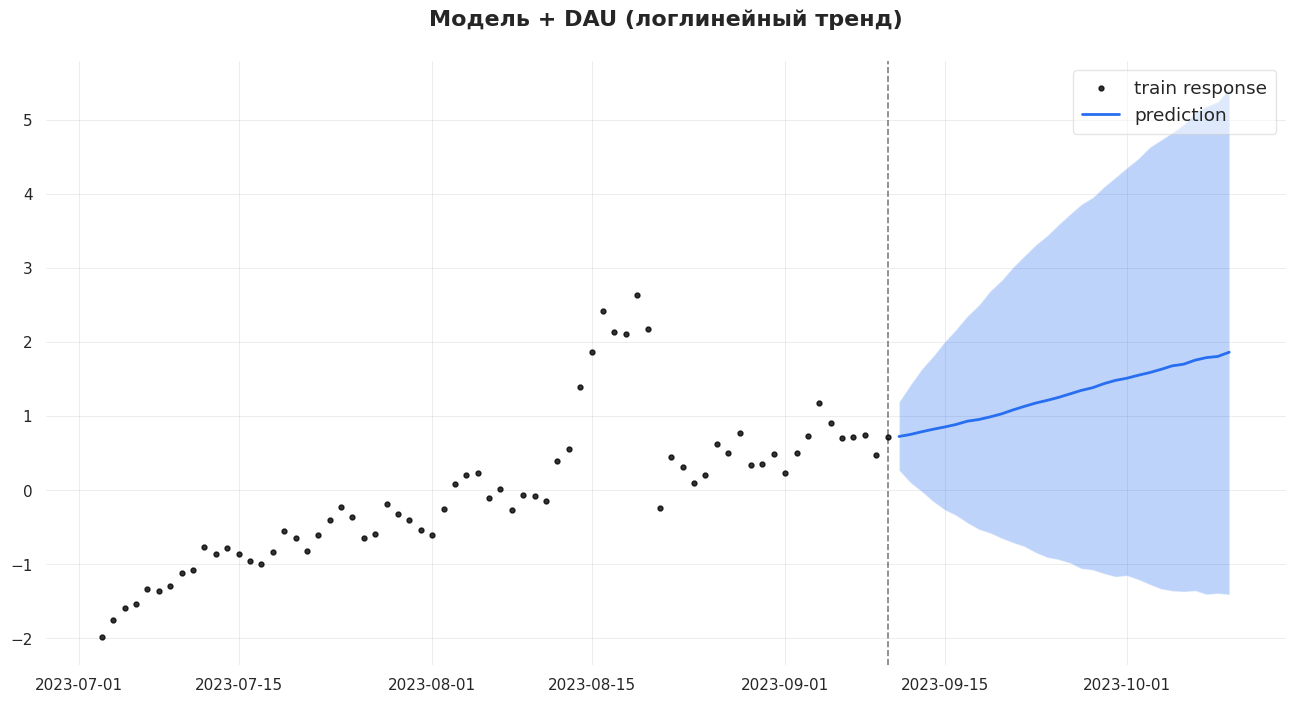

In [26]:
_ = plot_predicted_data(act_df, pred_4, "day_time", 'act_stand', title='Модель + DAU (логлинейный тренд)')

Наконец, попробуем добавить бинарную переменную:

In [27]:
futur["anomaly"] = 0
futur.head()

,day_time,DAU_stand,anomaly
0,2023-09-11,1.014788,0
1,2023-09-12,1.034454,0
2,2023-09-13,1.063135,0
3,2023-09-14,1.095227,0
4,2023-09-15,1.130807,0


In [28]:
pred_5 = model_list[4].predict(futur)
pred_6 = model_list[5].predict(futur)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

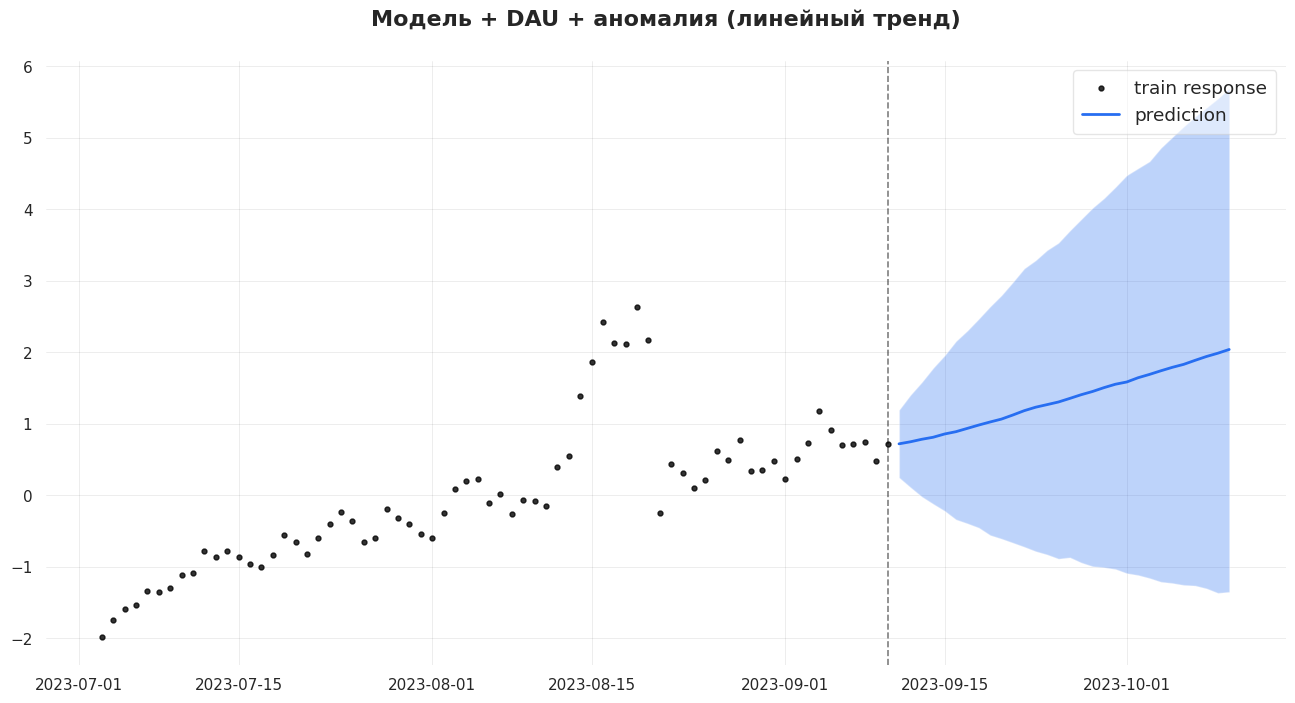

In [29]:
_ = plot_predicted_data(act_df, pred_5, "day_time", 'act_stand', title='Модель + DAU + аномалия (линейный тренд)')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

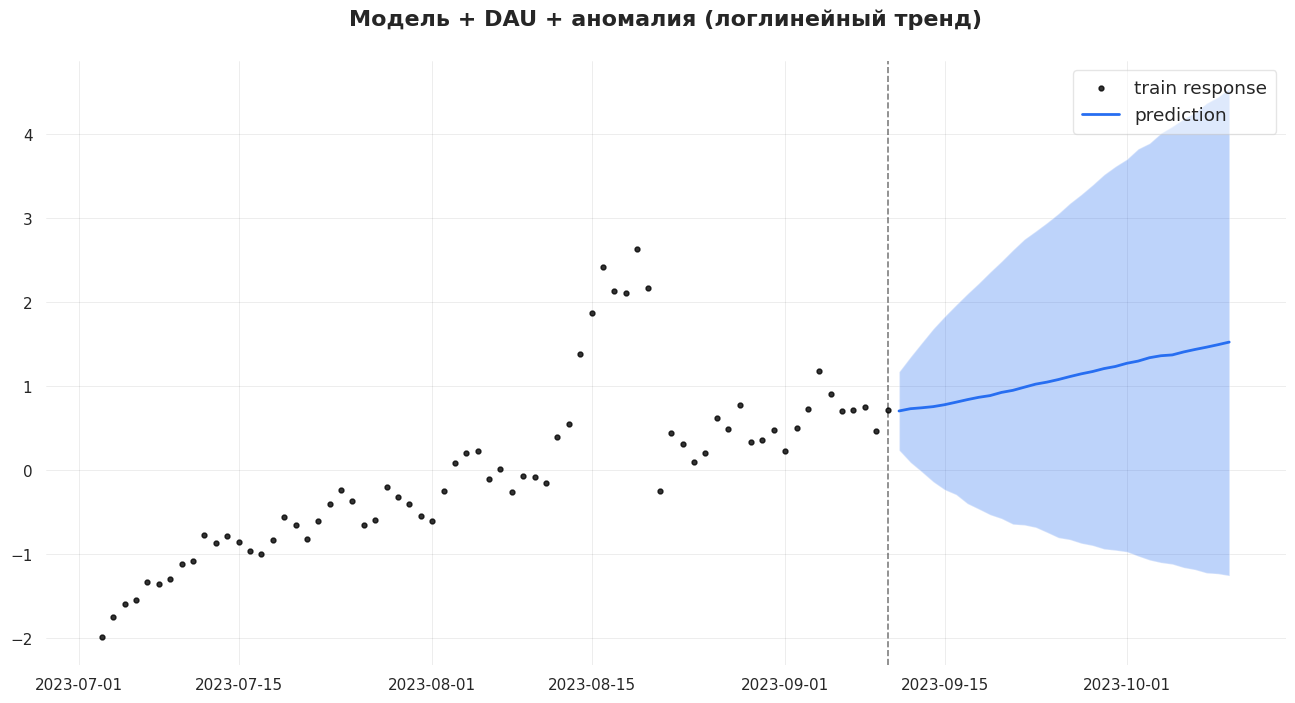

In [30]:
_ = plot_predicted_data(act_df, pred_6, "day_time", 'act_stand', title='Модель + DAU + аномалия (логлинейный тренд)')

# Оцениваем качество

Данные, на которых строится модель, должны быть как минимум не меньше того диапазона, на который делается прогноз. А желательно вообще соотношение 80/20, то есть имеющихся десяти недель не в полной мере достаточно для прогнозирование на месяц и более достоверный прогноз мы могли бы сделать примерно на две недели, но в рамках имеющейся задачи мы сделаем допущение, что прогоз на две недели сильно не отличается от прогноза на месяц. 

In [31]:
#сделаем список для бэктестеров
#начнём со скользящего

test_list_rolling = []

for model in model_list:
    
    backtester = BackTester(
    model=model,
    df=act_df,
    min_train_len=7,
    incremental_len=7,
    forecast_len=7,
    window_type="rolling")
    
    backtester.fit_predict()
    
    test_list_rolling.append(backtester)

2023-09-14 10:17:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:17:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:17:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:17:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:17:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:17:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:17:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:17:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:17:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:17:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:17:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:17:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:17:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:18:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:18:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:18:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:18:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:18:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:18:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:18:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:18:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:18:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:18:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:18:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:18:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:18:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:19:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:19:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:19:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:19:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:19:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:19:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:19:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:19:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:19:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:19:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:19:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:20:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:20:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:20:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:20:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:20:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:20:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:20:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:20:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:20:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:20:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:20:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:21:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:21:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:21:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:21:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:21:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:21:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [32]:
test_list_exp = []

for model in model_list:
    
    backtester = BackTester(
    model=model,
    df=act_df,
    min_train_len=7,
    incremental_len=7,
    forecast_len=7,
    window_type="expanding")
    
    backtester.fit_predict()
    
    test_list_exp.append(backtester)

2023-09-14 10:21:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:21:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:21:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:21:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:21:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:22:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:22:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:22:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:22:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:22:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:23:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:23:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:23:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:23:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:23:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:23:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:23:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:24:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:24:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:24:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:24:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:24:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:24:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:25:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:25:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:25:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:25:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:26:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:26:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:26:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:26:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:26:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:26:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:27:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:27:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:27:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:27:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:28:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:28:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:28:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:28:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:28:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:28:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:29:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:29:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:29:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:30:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:30:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:30:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:30:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:30:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:30:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:31:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:31:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Посмотрим, что получилось:

In [33]:
roll_df = []

for number, tester in enumerate(test_list_rolling):
    
    inter_df = tester.score()
    inter_df.insert(0, "model_number", number + 1)
    
    roll_df.append(inter_df)
    
roll_df = pd.concat(roll_df)
roll_df = roll_df.set_index("model_number")

In [34]:
roll_df.head()

,metric_name,metric_values,is_training_metric
model_number,,,
1,smape,0.884575,False
1,wmape,1.005043,False
1,mape,2.678704,False
1,mse,1.088786,False
1,mae,0.696057,False


In [35]:
for metric in roll_df.metric_name.unique():
    
    winning_model = roll_df.loc[roll_df.metric_name == metric].metric_values.idxmin()
    
    print(f"Самая лучшая модель по метрике {metric} - {winning_model}")

Самая лучшая модель по метрике smape - 2
Самая лучшая модель по метрике wmape - 2
Самая лучшая модель по метрике mape - 6
Самая лучшая модель по метрике mse - 6
Самая лучшая модель по метрике mae - 2
Самая лучшая модель по метрике rmsse - 6


Лучшие показатели у второй и шейстой моделей

In [36]:
exp_df = []

for number, tester in enumerate(test_list_exp):
    
    inter_df = tester.score()
    inter_df.insert(0, "model_number", number + 1)
    
    exp_df.append(inter_df)
    
exp_df = pd.concat(exp_df)
exp_df = exp_df.set_index("model_number")

In [37]:
for metric in exp_df.metric_name.unique():
    
    winning_model = exp_df.loc[exp_df.metric_name == metric].metric_values.idxmin()
    
    print(f"Самая лучшая модель по метрике {metric} - {winning_model}")

Самая лучшая модель по метрике smape - 4
Самая лучшая модель по метрике wmape - 2
Самая лучшая модель по метрике mape - 6
Самая лучшая модель по метрике mse - 5
Самая лучшая модель по метрике mae - 2
Самая лучшая модель по метрике rmsse - 5


Лучшие показатели у второй и пятой моделей, но есть и метрики по которым лучшей вырбрана модель 4 или 6

Что по этому поводу скажет WBIC?

In [38]:
for model in model_list:
    
    model.fit_wbic(act_df)

2023-09-14 10:34:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 4.248, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:34:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 4.248, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:34:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 4.248, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:34:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 4.248, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:35:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 4.248, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-09-14 10:35:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 4.248, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [39]:
for number, model in enumerate(model_list):
    
    print(f"Модель №{number+1}, WBIC = {model.get_wbic()}")

Модель №1, WBIC = 57.22596972742673
Модель №2, WBIC = 55.61081855220572
Модель №3, WBIC = 52.15513948818942
Модель №4, WBIC = 49.51966928408892
Модель №5, WBIC = 47.27389958400982
Модель №6, WBIC = 44.92946131701725


Таким образом, мы скорее склоняемся к модели №6!

# Дополнительный анализ модели №6

Посмотрим пару дополнительных штук относительно последней модели:

In [40]:
comps = model_list[5].predict(futur, decompose=True)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

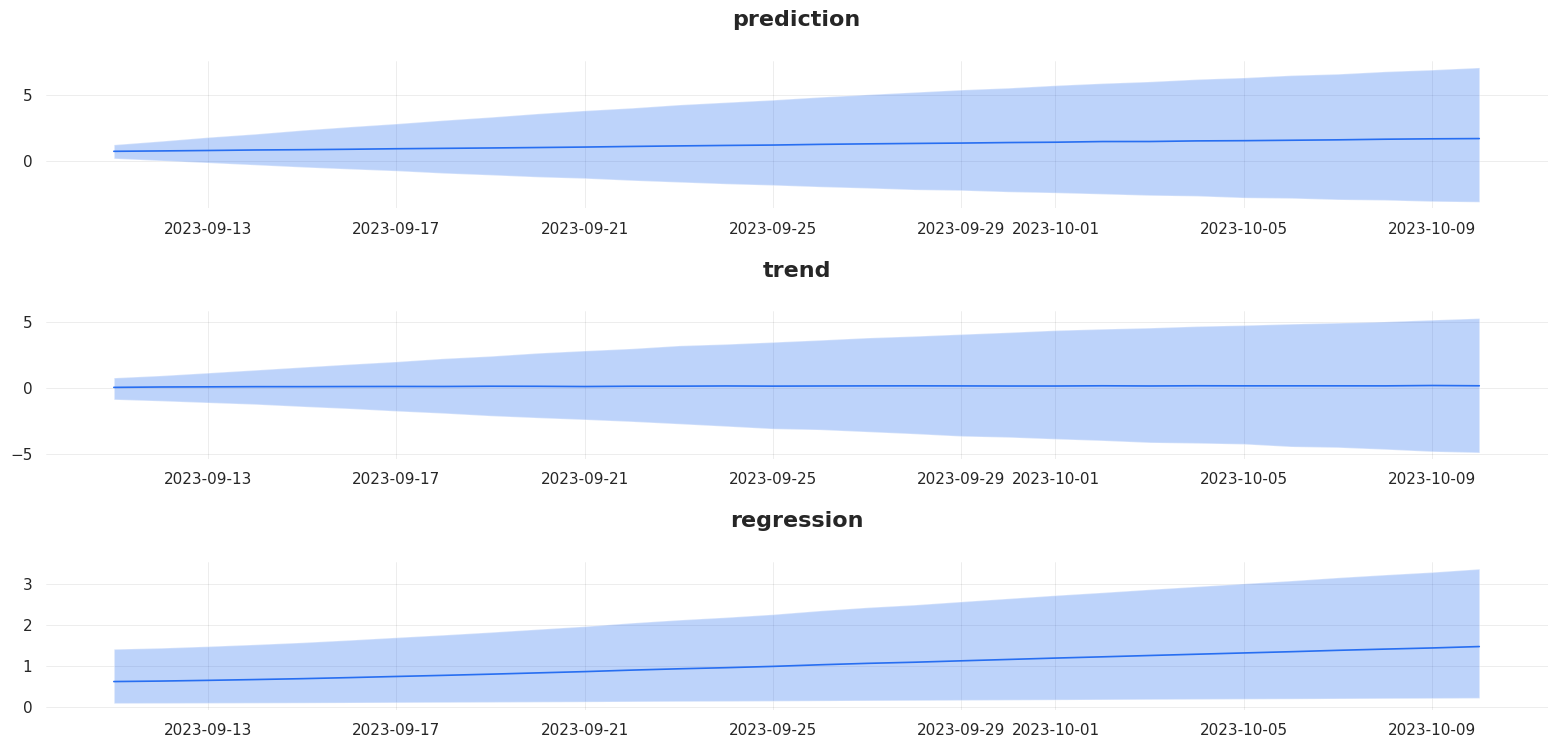

In [41]:
_ = plot_predicted_components(comps, "day_time", plot_components=['prediction', 'trend', 'regression'])

In [42]:
comps.head()

,day_time,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_5,seasonality,seasonality_95,regression_5,regression,regression_95
0,2023-09-11,0.171585,0.705081,1.225985,-0.845912,0.059277,0.799600,0.0,0.0,0.0,0.091870,0.617658,1.414457
1,2023-09-12,0.009460,0.734490,1.496882,-0.957065,0.088442,0.966261,0.0,0.0,0.0,0.093651,0.629628,1.441868
2,2023-09-13,-0.152099,0.767577,1.790797,-1.087246,0.099294,1.176849,0.0,0.0,0.0,0.096247,0.647085,1.481845
3,2023-09-14,-0.319184,0.806775,2.040567,-1.212455,0.112405,1.391349,0.0,0.0,0.0,0.099153,0.666617,1.526575
4,2023-09-15,-0.489022,0.828217,2.331716,-1.383862,0.113749,1.611288,0.0,0.0,0.0,0.102374,0.688273,1.576168


In [43]:
comps.tail()

,day_time,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_5,seasonality,seasonality_95,regression_5,regression,regression_95
25,2023-10-06,-2.862840,1.548494,6.513176,-4.421579,0.176238,4.885852,0.0,0.0,0.0,0.200281,1.346517,3.083568
26,2023-10-07,-2.965124,1.580565,6.618984,-4.481855,0.175470,4.968087,0.0,0.0,0.0,0.205311,1.380337,3.161016
27,2023-10-08,-3.006445,1.628259,6.803556,-4.625092,0.173461,5.056744,0.0,0.0,0.0,0.209762,1.410261,3.229544
28,2023-10-09,-3.101554,1.658209,6.936378,-4.791221,0.201987,5.189059,0.0,0.0,0.0,0.213901,1.438088,3.293269
29,2023-10-10,-3.142734,1.676850,7.102665,-4.872971,0.180300,5.312226,0.0,0.0,0.0,0.218984,1.472260,3.371524


In [44]:
ps = model_list[5].get_posterior_samples(relabel=True, permute=False)
ps.keys()

dict_keys(['l', 'b', 'lev_sm', 'slp_sm', 'obs_sigma', 'nu', 'lt_sum', 'gt_sum', 'gb', 'gl', 'loglk', 'DAU_stand', 'anomaly'])

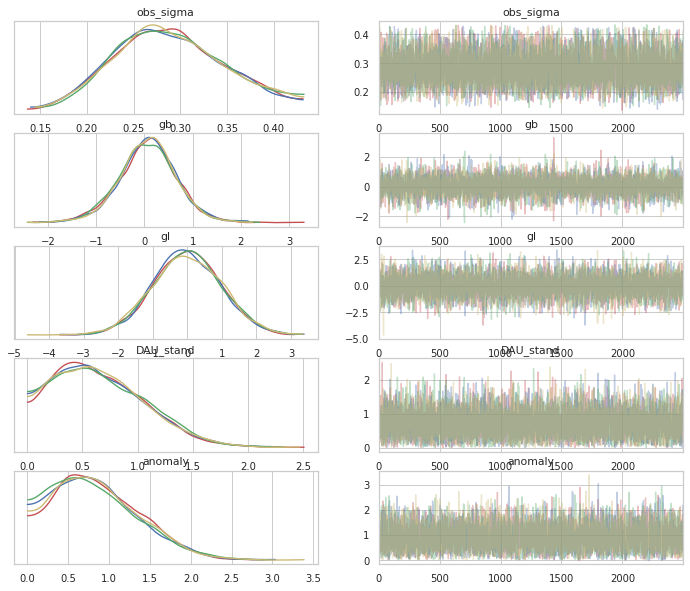

In [45]:
az.plot_trace(
    ps,
    var_names=['obs_sigma', 'gb', 'gl', 'DAU_stand', 'anomaly'],
    chain_prop={"color": ['r', 'b', 'g', 'y']},
);

А теперь переведём предсказание в оригинальные единицы измерения:

In [46]:
pred_6[["prediction_5", "prediction", "prediction_95"]] = pred_6[["prediction_5", "prediction", "prediction_95"]] \
                         .apply(lambda x: (x * act_sd) + act_mean)

<Axes: xlabel='day_time'>

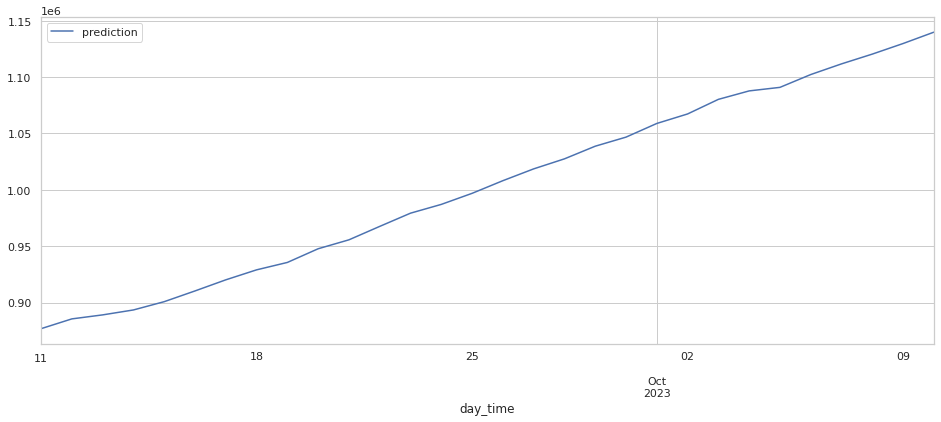

In [52]:
pred_6.plot(x='day_time', y='prediction')